In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import initializers

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
#load the data
data = pd.read_csv('outputs/density-data-all-100-stdev', sep=" ", header=None)
data.head()
data.columns = ['rho', 'potential', 'temp', 'stdev_pe', 'stdev_temp']

# data = data.sample(frac=1)
# print(data[0:15])
# data = data[0:15]

x = data.drop(['potential', 'temp'], axis=1)
#error_bars = data.drop(['rho', 'potential', 'temp'], axis=1)
y = data.drop(['rho', 'stdev_pe', 'stdev_temp'], axis=1)


#split the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
error_bars_train = x_train.drop(['rho'], axis=1)
x_train = x_train.rho
error_bars_test = x_test.drop(['rho'], axis=1)
x_test = x_test.rho

# x_train = [x_train[0:2]]
# y_train = [y_train[0:2]]
# x_test = x_train
# y_test = y_train
#print(x)
#print(y,"\n\n")
print("\n test data:", x_test[0:50], "\n", y_test[0:50])
# print("\n train data:",x_train,"\n",y_train)


 test data: 790    0.899
171    0.280
270    0.379
576    0.685
292    0.401
572    0.681
727    0.836
819    0.928
48     0.157
715    0.824
155    0.264
140    0.249
662    0.771
63     0.172
681    0.790
786    0.895
683    0.792
182    0.291
92     0.201
716    0.825
236    0.345
767    0.876
737    0.846
444    0.553
297    0.406
6      0.115
522    0.631
551    0.660
555    0.664
777    0.886
145    0.254
482    0.591
615    0.724
276    0.385
224    0.333
151    0.260
467    0.576
676    0.785
837    0.946
238    0.347
75     0.184
565    0.674
129    0.238
652    0.761
344    0.453
392    0.501
490    0.599
390    0.499
589    0.698
593    0.702
Name: rho, dtype: float64 
      potential   temp
790     -4.895  1.172
171     -3.534  0.714
270     -3.612  0.765
576     -4.039  1.026
292     -3.621  0.772
572     -4.019  1.016
727     -4.641  1.224
819     -5.014  1.133
48      -3.484  0.680
715     -4.593  1.223
155     -3.508  0.697
140     -3.508  0.696
662     -4.389  1.183
6

In [5]:
#Normalization
x_train_reshape = x_train.values.reshape((-1,1))
x_test_reshape = x_test.values.reshape((-1,1))

y_train_reshape = y_train.values.reshape((-1,2))
y_test_reshape = y_test.values.reshape((-1,2))

# print(y_train_reshape)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

scaler_x.fit(x_train_reshape)
xtrain_scale=scaler_x.transform(x_train_reshape)
scaler_x.fit(x_test_reshape)
xtest_scale=scaler_x.transform(x_test_reshape)
scaler_y.fit(y_train_reshape)
ytrain_scale=scaler_y.transform(y_train_reshape)
scaler_y.fit(y_test_reshape)
ytest_scale=scaler_y.transform(y_test_reshape)
# print(xtrain_scale)
# print(ytrain_scale)

In [ ]:
def custom_accuracy (y_actual, y_predicted):
  # predictions_transformed = scaler_y.inverse_transform(y_predicted)
  lower_limit = y_actual - error_bars_test.stdev_pe
  upper_limit = y_actual + error_bars_test.stdev_pe
  hits = 0
  filter = tf.math.logical_and(y_predicted >= lower_limit, y_predicted < upper_limit, name="and")
  hits = tf.sum(filter)

  return hits/169
# print("Accuracy:",acc*100, "% hits:", hits, " ", i)

In [5]:
#define the model
model = keras.Sequential()
model.add(Dense(1, input_dim=1, kernel_initializer= tf.keras.initializers.Ones(), activation='relu', name='input_layer'))
model.add(Dense(5, activation='relu', name="hidden_layer"))
model.add(Dense(2, activation='linear', name="output_layer"))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.summary()
# 'random_uniform'

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 1)                 2         
_________________________________________________________________
hidden_layer (Dense)         (None, 5)                 10        
_________________________________________________________________
output_layer (Dense)         (None, 2)                 12        
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________


In [6]:
#compile the model
model.compile(loss='mse', optimizer=opt, metrics=['mae', 'accuracy'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=600, batch_size=5, verbose=1, validation_split=0.2)
# think about supplying error_bars here


Train on 538 samples, validate on 135 samples
Epoch 1/600
538/538 [==============================] - 0s 358us/sample - loss: 0.5700 - mean_absolute_error: 0.6136 - acc: 0.6599 - val_loss: 0.4710 - val_mean_absolute_error: 0.5524 - val_acc: 0.5037
Epoch 2/600
538/538 [==============================] - 0s 149us/sample - loss: 0.3648 - mean_absolute_error: 0.4915 - acc: 0.6803 - val_loss: 0.3376 - val_mean_absolute_error: 0.4715 - val_acc: 0.6222
Epoch 3/600
538/538 [==============================] - 0s 140us/sample - loss: 0.2795 - mean_absolute_error: 0.4295 - acc: 0.6952 - val_loss: 0.2718 - val_mean_absolute_error: 0.4275 - val_acc: 0.6222
Epoch 4/600
538/538 [==============================] - 0s 145us/sample - loss: 0.2289 - mean_absolute_error: 0.3913 - acc: 0.6952 - val_loss: 0.2279 - val_mean_absolute_error: 0.3976 - val_acc: 0.6222
Epoch 5/600
538/538 [==============================] - 0s 150us/sample - loss: 0.1930 - mean_absolute_error: 0.3660 - acc: 0.6952 - val_loss: 0.1957 -

Epoch 82/600
538/538 [==============================] - 0s 150us/sample - loss: 0.0036 - mean_absolute_error: 0.0455 - acc: 0.9907 - val_loss: 0.0046 - val_mean_absolute_error: 0.0510 - val_acc: 1.0000
Epoch 83/600
538/538 [==============================] - 0s 148us/sample - loss: 0.0036 - mean_absolute_error: 0.0453 - acc: 0.9907 - val_loss: 0.0044 - val_mean_absolute_error: 0.0503 - val_acc: 1.0000
Epoch 84/600
538/538 [==============================] - 0s 149us/sample - loss: 0.0035 - mean_absolute_error: 0.0448 - acc: 0.9944 - val_loss: 0.0042 - val_mean_absolute_error: 0.0490 - val_acc: 1.0000
Epoch 85/600
538/538 [==============================] - 0s 149us/sample - loss: 0.0035 - mean_absolute_error: 0.0443 - acc: 0.9926 - val_loss: 0.0042 - val_mean_absolute_error: 0.0489 - val_acc: 1.0000
Epoch 86/600
538/538 [==============================] - 0s 148us/sample - loss: 0.0035 - mean_absolute_error: 0.0440 - acc: 0.9944 - val_loss: 0.0042 - val_mean_absolute_error: 0.0503 - val_ac

Epoch 162/600
538/538 [==============================] - 0s 148us/sample - loss: 5.9345e-04 - mean_absolute_error: 0.0190 - acc: 0.9981 - val_loss: 6.6805e-04 - val_mean_absolute_error: 0.0196 - val_acc: 1.0000
Epoch 163/600
538/538 [==============================] - 0s 149us/sample - loss: 5.6781e-04 - mean_absolute_error: 0.0188 - acc: 0.9963 - val_loss: 5.4889e-04 - val_mean_absolute_error: 0.0181 - val_acc: 1.0000
Epoch 164/600
538/538 [==============================] - 0s 151us/sample - loss: 5.5605e-04 - mean_absolute_error: 0.0184 - acc: 0.9963 - val_loss: 5.3437e-04 - val_mean_absolute_error: 0.0178 - val_acc: 1.0000
Epoch 165/600
538/538 [==============================] - 0s 150us/sample - loss: 5.3385e-04 - mean_absolute_error: 0.0182 - acc: 1.0000 - val_loss: 5.1584e-04 - val_mean_absolute_error: 0.0175 - val_acc: 1.0000
Epoch 166/600
538/538 [==============================] - 0s 150us/sample - loss: 5.0146e-04 - mean_absolute_error: 0.0177 - acc: 0.9963 - val_loss: 6.2483e-

Epoch 201/600
538/538 [==============================] - 0s 142us/sample - loss: 2.5803e-04 - mean_absolute_error: 0.0122 - acc: 0.9963 - val_loss: 2.7864e-04 - val_mean_absolute_error: 0.0126 - val_acc: 1.0000
Epoch 202/600
538/538 [==============================] - 0s 154us/sample - loss: 2.8023e-04 - mean_absolute_error: 0.0130 - acc: 0.9963 - val_loss: 2.7410e-04 - val_mean_absolute_error: 0.0126 - val_acc: 1.0000
Epoch 203/600
538/538 [==============================] - 0s 172us/sample - loss: 2.9333e-04 - mean_absolute_error: 0.0127 - acc: 0.9963 - val_loss: 2.6619e-04 - val_mean_absolute_error: 0.0122 - val_acc: 1.0000
Epoch 204/600
538/538 [==============================] - 0s 174us/sample - loss: 2.5770e-04 - mean_absolute_error: 0.0122 - acc: 0.9963 - val_loss: 3.9512e-04 - val_mean_absolute_error: 0.0138 - val_acc: 1.0000
Epoch 205/600
538/538 [==============================] - 0s 183us/sample - loss: 2.8066e-04 - mean_absolute_error: 0.0123 - acc: 1.0000 - val_loss: 2.6128e-

Epoch 240/600
538/538 [==============================] - 0s 153us/sample - loss: 3.0816e-04 - mean_absolute_error: 0.0129 - acc: 0.9981 - val_loss: 3.2358e-04 - val_mean_absolute_error: 0.0139 - val_acc: 1.0000
Epoch 241/600
538/538 [==============================] - 0s 147us/sample - loss: 2.3260e-04 - mean_absolute_error: 0.0114 - acc: 0.9963 - val_loss: 2.4194e-04 - val_mean_absolute_error: 0.0118 - val_acc: 1.0000
Epoch 242/600
538/538 [==============================] - 0s 149us/sample - loss: 2.3179e-04 - mean_absolute_error: 0.0113 - acc: 0.9963 - val_loss: 4.8151e-04 - val_mean_absolute_error: 0.0167 - val_acc: 1.0000
Epoch 243/600
538/538 [==============================] - 0s 184us/sample - loss: 2.4666e-04 - mean_absolute_error: 0.0116 - acc: 0.9963 - val_loss: 2.3766e-04 - val_mean_absolute_error: 0.0110 - val_acc: 1.0000
Epoch 244/600
538/538 [==============================] - 0s 209us/sample - loss: 2.2992e-04 - mean_absolute_error: 0.0113 - acc: 0.9944 - val_loss: 2.5442e-

Epoch 279/600
538/538 [==============================] - 0s 145us/sample - loss: 2.2121e-04 - mean_absolute_error: 0.0108 - acc: 0.9944 - val_loss: 2.2454e-04 - val_mean_absolute_error: 0.0105 - val_acc: 1.0000
Epoch 280/600
538/538 [==============================] - 0s 148us/sample - loss: 2.3118e-04 - mean_absolute_error: 0.0110 - acc: 0.9981 - val_loss: 2.4382e-04 - val_mean_absolute_error: 0.0106 - val_acc: 1.0000
Epoch 281/600
538/538 [==============================] - 0s 155us/sample - loss: 2.3104e-04 - mean_absolute_error: 0.0111 - acc: 0.9963 - val_loss: 2.4920e-04 - val_mean_absolute_error: 0.0106 - val_acc: 1.0000
Epoch 282/600
538/538 [==============================] - 0s 152us/sample - loss: 2.3835e-04 - mean_absolute_error: 0.0111 - acc: 0.9963 - val_loss: 2.2630e-04 - val_mean_absolute_error: 0.0108 - val_acc: 1.0000
Epoch 283/600
538/538 [==============================] - 0s 147us/sample - loss: 2.0287e-04 - mean_absolute_error: 0.0105 - acc: 0.9963 - val_loss: 2.4635e-

Epoch 318/600
538/538 [==============================] - 0s 154us/sample - loss: 2.0887e-04 - mean_absolute_error: 0.0106 - acc: 0.9963 - val_loss: 2.4134e-04 - val_mean_absolute_error: 0.0116 - val_acc: 1.0000
Epoch 319/600
538/538 [==============================] - 0s 148us/sample - loss: 2.2923e-04 - mean_absolute_error: 0.0110 - acc: 0.9963 - val_loss: 2.6977e-04 - val_mean_absolute_error: 0.0116 - val_acc: 1.0000
Epoch 320/600
538/538 [==============================] - 0s 148us/sample - loss: 2.2573e-04 - mean_absolute_error: 0.0109 - acc: 0.9963 - val_loss: 2.2798e-04 - val_mean_absolute_error: 0.0105 - val_acc: 1.0000
Epoch 321/600
538/538 [==============================] - 0s 150us/sample - loss: 2.0965e-04 - mean_absolute_error: 0.0105 - acc: 0.9963 - val_loss: 2.3042e-04 - val_mean_absolute_error: 0.0108 - val_acc: 1.0000
Epoch 322/600
538/538 [==============================] - 0s 149us/sample - loss: 2.2234e-04 - mean_absolute_error: 0.0107 - acc: 0.9963 - val_loss: 2.2929e-

Epoch 357/600
538/538 [==============================] - 0s 146us/sample - loss: 2.3529e-04 - mean_absolute_error: 0.0113 - acc: 0.9963 - val_loss: 2.4237e-04 - val_mean_absolute_error: 0.0107 - val_acc: 1.0000
Epoch 358/600
538/538 [==============================] - 0s 150us/sample - loss: 2.3152e-04 - mean_absolute_error: 0.0109 - acc: 0.9944 - val_loss: 2.2194e-04 - val_mean_absolute_error: 0.0100 - val_acc: 1.0000
Epoch 359/600
538/538 [==============================] - 0s 149us/sample - loss: 2.1121e-04 - mean_absolute_error: 0.0104 - acc: 0.9944 - val_loss: 2.6138e-04 - val_mean_absolute_error: 0.0110 - val_acc: 1.0000
Epoch 360/600
538/538 [==============================] - 0s 149us/sample - loss: 2.2533e-04 - mean_absolute_error: 0.0110 - acc: 0.9926 - val_loss: 2.4241e-04 - val_mean_absolute_error: 0.0113 - val_acc: 1.0000
Epoch 361/600
538/538 [==============================] - 0s 148us/sample - loss: 2.1004e-04 - mean_absolute_error: 0.0104 - acc: 0.9963 - val_loss: 2.2201e-

Epoch 396/600
538/538 [==============================] - 0s 149us/sample - loss: 2.1010e-04 - mean_absolute_error: 0.0105 - acc: 1.0000 - val_loss: 2.3098e-04 - val_mean_absolute_error: 0.0102 - val_acc: 1.0000
Epoch 397/600
538/538 [==============================] - 0s 150us/sample - loss: 2.0978e-04 - mean_absolute_error: 0.0103 - acc: 0.9963 - val_loss: 2.7228e-04 - val_mean_absolute_error: 0.0121 - val_acc: 1.0000
Epoch 398/600
538/538 [==============================] - 0s 149us/sample - loss: 2.1715e-04 - mean_absolute_error: 0.0103 - acc: 0.9963 - val_loss: 2.7987e-04 - val_mean_absolute_error: 0.0109 - val_acc: 1.0000
Epoch 399/600
538/538 [==============================] - 0s 145us/sample - loss: 2.3174e-04 - mean_absolute_error: 0.0108 - acc: 0.9963 - val_loss: 2.3782e-04 - val_mean_absolute_error: 0.0112 - val_acc: 1.0000
Epoch 400/600
538/538 [==============================] - 0s 150us/sample - loss: 2.2512e-04 - mean_absolute_error: 0.0107 - acc: 0.9963 - val_loss: 2.7915e-

Epoch 435/600
538/538 [==============================] - 0s 148us/sample - loss: 2.0688e-04 - mean_absolute_error: 0.0102 - acc: 0.9981 - val_loss: 2.4322e-04 - val_mean_absolute_error: 0.0111 - val_acc: 1.0000
Epoch 436/600
538/538 [==============================] - 0s 148us/sample - loss: 2.1362e-04 - mean_absolute_error: 0.0105 - acc: 0.9944 - val_loss: 2.7769e-04 - val_mean_absolute_error: 0.0114 - val_acc: 1.0000
Epoch 437/600
538/538 [==============================] - 0s 148us/sample - loss: 2.0925e-04 - mean_absolute_error: 0.0104 - acc: 0.9963 - val_loss: 2.2726e-04 - val_mean_absolute_error: 0.0102 - val_acc: 1.0000
Epoch 438/600
538/538 [==============================] - 0s 147us/sample - loss: 2.0671e-04 - mean_absolute_error: 0.0104 - acc: 0.9944 - val_loss: 2.3703e-04 - val_mean_absolute_error: 0.0100 - val_acc: 1.0000
Epoch 439/600
538/538 [==============================] - 0s 139us/sample - loss: 2.1614e-04 - mean_absolute_error: 0.0104 - acc: 0.9963 - val_loss: 2.2141e-

Epoch 474/600
538/538 [==============================] - 0s 149us/sample - loss: 2.1507e-04 - mean_absolute_error: 0.0104 - acc: 0.9944 - val_loss: 2.5541e-04 - val_mean_absolute_error: 0.0107 - val_acc: 1.0000
Epoch 475/600
538/538 [==============================] - 0s 149us/sample - loss: 2.3974e-04 - mean_absolute_error: 0.0111 - acc: 0.9963 - val_loss: 2.3723e-04 - val_mean_absolute_error: 0.0112 - val_acc: 1.0000
Epoch 476/600
538/538 [==============================] - 0s 146us/sample - loss: 2.1075e-04 - mean_absolute_error: 0.0103 - acc: 0.9944 - val_loss: 3.1508e-04 - val_mean_absolute_error: 0.0112 - val_acc: 1.0000
Epoch 477/600
538/538 [==============================] - 0s 153us/sample - loss: 2.3259e-04 - mean_absolute_error: 0.0106 - acc: 0.9963 - val_loss: 2.2794e-04 - val_mean_absolute_error: 0.0100 - val_acc: 1.0000
Epoch 478/600
538/538 [==============================] - 0s 154us/sample - loss: 2.1640e-04 - mean_absolute_error: 0.0106 - acc: 0.9981 - val_loss: 2.4000e-

Epoch 513/600
538/538 [==============================] - 0s 149us/sample - loss: 2.2813e-04 - mean_absolute_error: 0.0107 - acc: 0.9981 - val_loss: 2.8339e-04 - val_mean_absolute_error: 0.0118 - val_acc: 1.0000
Epoch 514/600
538/538 [==============================] - 0s 149us/sample - loss: 2.3093e-04 - mean_absolute_error: 0.0111 - acc: 0.9963 - val_loss: 2.6402e-04 - val_mean_absolute_error: 0.0103 - val_acc: 1.0000
Epoch 515/600
538/538 [==============================] - 0s 149us/sample - loss: 2.2626e-04 - mean_absolute_error: 0.0106 - acc: 0.9963 - val_loss: 2.3838e-04 - val_mean_absolute_error: 0.0105 - val_acc: 1.0000
Epoch 516/600
538/538 [==============================] - 0s 150us/sample - loss: 2.2274e-04 - mean_absolute_error: 0.0104 - acc: 0.9981 - val_loss: 2.2746e-04 - val_mean_absolute_error: 0.0100 - val_acc: 1.0000
Epoch 517/600
538/538 [==============================] - 0s 150us/sample - loss: 2.0638e-04 - mean_absolute_error: 0.0102 - acc: 0.9944 - val_loss: 2.3825e-

Epoch 552/600
538/538 [==============================] - 0s 148us/sample - loss: 2.2073e-04 - mean_absolute_error: 0.0106 - acc: 0.9963 - val_loss: 2.4562e-04 - val_mean_absolute_error: 0.0108 - val_acc: 1.0000
Epoch 553/600
538/538 [==============================] - 0s 151us/sample - loss: 2.2521e-04 - mean_absolute_error: 0.0107 - acc: 0.9981 - val_loss: 2.7916e-04 - val_mean_absolute_error: 0.0116 - val_acc: 1.0000
Epoch 554/600
538/538 [==============================] - 0s 149us/sample - loss: 2.0174e-04 - mean_absolute_error: 0.0103 - acc: 0.9944 - val_loss: 3.1228e-04 - val_mean_absolute_error: 0.0112 - val_acc: 1.0000
Epoch 555/600
538/538 [==============================] - 0s 158us/sample - loss: 2.3083e-04 - mean_absolute_error: 0.0107 - acc: 0.9963 - val_loss: 2.3663e-04 - val_mean_absolute_error: 0.0098 - val_acc: 1.0000
Epoch 556/600
538/538 [==============================] - 0s 182us/sample - loss: 2.0542e-04 - mean_absolute_error: 0.0103 - acc: 0.9963 - val_loss: 2.2918e-

Epoch 591/600
538/538 [==============================] - 0s 145us/sample - loss: 2.1148e-04 - mean_absolute_error: 0.0103 - acc: 0.9944 - val_loss: 2.4948e-04 - val_mean_absolute_error: 0.0102 - val_acc: 1.0000
Epoch 592/600
538/538 [==============================] - 0s 149us/sample - loss: 2.1176e-04 - mean_absolute_error: 0.0103 - acc: 0.9963 - val_loss: 2.4623e-04 - val_mean_absolute_error: 0.0109 - val_acc: 1.0000
Epoch 593/600
538/538 [==============================] - 0s 147us/sample - loss: 2.1862e-04 - mean_absolute_error: 0.0105 - acc: 0.9963 - val_loss: 2.3218e-04 - val_mean_absolute_error: 0.0103 - val_acc: 1.0000
Epoch 594/600
538/538 [==============================] - 0s 149us/sample - loss: 2.0810e-04 - mean_absolute_error: 0.0102 - acc: 0.9963 - val_loss: 2.5100e-04 - val_mean_absolute_error: 0.0109 - val_acc: 1.0000
Epoch 595/600
538/538 [==============================] - 0s 149us/sample - loss: 2.0784e-04 - mean_absolute_error: 0.0105 - acc: 0.9963 - val_loss: 2.2543e-

In [6]:
new_model = keras.models.load_model("model_5neurons_0.001LR_600epoch_5batch")
predictions = new_model.predict(xtest_scale)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# model.save("/content/drive/MyDrive/Colab Notebooks/model_5neurons_0.001LR_600epoch_5batch") #"/content/drive/MyDrive/Colab Notebooks/mymodel")
# model.save_weights('/content/drive/MyDrive/Colab Notebooks/checkpoints/my_checkpoint')

In [ ]:
# predictions = new_model.predict(xtest_scale)
#print(history.history.keys())
#print(history.history.get('acc')[-1])
# "Loss"
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.yscale('log')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train','validation'], loc='upper right')
# plt.show()

In [7]:
predictions_transformed = scaler_y.inverse_transform(predictions)
# predictions_transformed2 = scaler_y.inverse_transform([predictions[50:100]])
# predictions_transformed3 = scaler_y.inverse_transform([predictions[100:]])
predicted_data = pd.DataFrame(predictions_transformed)
predicted_data.columns = ['pe', 'temp']
# print(y_test)
#calculating accuracy
hits = 0
i = 0
print(y_test.shape)
for index, row in y_test.iterrows():
  lower_limit = row['potential']-error_bars_test.stdev_pe[index]
  upper_limit = row['potential']+error_bars_test.stdev_pe[index]
  #print("\n upper limit:",upper_limit," lower limit:",lower_limit," prediction:",predicted_data.pe[i])
  if predicted_data.pe[i] > lower_limit and predicted_data.pe[i] < upper_limit:
    # print(" hit")
    hits += 1
  print(x_test[index],",", y_test.potential[index],",",predicted_data.pe[i],",",error_bars_test.stdev_pe[index])
  i+=1

acc = hits/(i)
print("Accuracy:",acc*100, "% hits:", hits, " ", i)

(169, 2)
0.899 , -4.895 , -4.899502 , 0.042
0.28 , -3.534 , -3.5458887 , 0.053
0.379 , -3.612 , -3.5924547 , 0.046
0.685 , -4.039 , -4.053472 , 0.03
0.401 , -3.6210000000000004 , -3.6028028 , 0.04
0.6809999999999999 , -4.019 , -4.0378857 , 0.031
0.836 , -4.641 , -4.646676 , 0.042
0.9279999999999999 , -5.013999999999999 , -5.015882 , 0.04
0.157 , -3.484 , -3.488034 , 0.055999999999999994
0.8240000000000001 , -4.593 , -4.598519 , 0.040999999999999995
0.264 , -3.508 , -3.5383625 , 0.053
0.249 , -3.508 , -3.5313075 , 0.062
0.7709999999999999 , -4.388999999999999 , -4.38857 , 0.038
0.172 , -3.492 , -3.495089 , 0.055
0.79 , -4.463 , -4.462603 , 0.042
0.895 , -4.881 , -4.883449 , 0.040999999999999995
0.792 , -4.471 , -4.470396 , 0.038
0.29100000000000004 , -3.55 , -3.5510626 , 0.040999999999999995
0.201 , -3.505 , -3.5087297 , 0.064
0.825 , -4.595 , -4.6025324 , 0.042
0.345 , -3.562 , -3.576462 , 0.04
0.8759999999999999 , -4.7989999999999995 , -4.8072 , 0.042
0.846 , -4.68 , -4.6868076 , 0.04

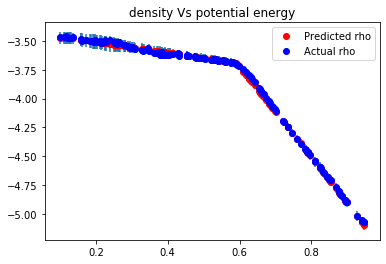

0    -4.899502
1    -3.545889
2    -3.592455
3    -4.053472
4    -3.602803
5    -4.037886
6    -4.646676
7    -5.015882
8    -3.488034
9    -4.598519
10   -3.538363
11   -3.531307
12   -4.388570
13   -3.495089
14   -4.462603
15   -4.883449
16   -4.470396
17   -3.551063
18   -3.508730
19   -4.602532
20   -3.576462
21   -4.807200
22   -4.686808
23   -3.674298
24   -3.605155
25   -3.477007
26   -3.843061
27   -3.956060
28   -3.971646
29   -4.847332
30   -3.533659
31   -3.692172
32   -4.205435
33   -3.595277
34   -3.570818
35   -3.536481
36   -3.685116
37   -4.443120
38   -5.088117
39   -3.577403
40   -3.500734
41   -4.010611
42   -3.526133
43   -4.349605
44   -3.627262
45   -3.649839
46   -3.718374
47   -3.648898
48   -4.104126
49   -4.119712
Name: pe, dtype: float32
790    0.042
171    0.053
270    0.046
576    0.030
292    0.040
572    0.031
727    0.042
819    0.040
48     0.056
715    0.041
155    0.053
140    0.062
662    0.038
63     0.055
681    0.042
786    0.041
683    0.038
182 

In [8]:
plt.plot(x_test,predicted_data.pe,"ro")
plt.plot(x_test,y_test.potential,"bo")
plt.errorbar(x_test, predicted_data.pe, yerr =error_bars_test.stdev_pe, fmt=" ")
plt.legend(['Predicted rho','Actual rho'], loc='upper right')
plt.title('density Vs potential energy')
plt.show()

print(predicted_data.pe[0:50])
print(error_bars_test.stdev_pe[0:50])